<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [44]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.io import decode_image
from torchvision.transforms import transforms as T
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

In [45]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tommykamaz/faces-dataset-small")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'faces-dataset-small' dataset.
Path to dataset files: /kaggle/input/faces-dataset-small


In [46]:
DIR = '/kaggle/input/faces-dataset-small/faces_dataset_small'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


In [47]:
class FlickDataset(Dataset):
  def __init__(self,data_dir=DIR,transform=None):
    self.img_dir = data_dir
    self.transform = transform
    self.image_files = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if f.endswith(('.png','.jpg','.jpeg'))]

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self,idx):
    img_path = self.image_files[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [105]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader
  transforms = T.Compose([
    T.Resize((image_size,image_size)),
    T.ToTensor(),
    T.Normalize(*stats)
  ])
  dataset = FlickDataset(DIR,transform=transforms)

  return DataLoader(dataset,batch_size=batch_size)

In [49]:
image_size = 128
batch_size=32
loader = get_dataloader(image_size,batch_size=batch_size)
#TODO: build dataloader and transfer it to device

## Часть 2. Построение и обучение модели (4 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [50]:
discriminator = nn.Sequential(
    # in 3x128x128
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    #out 64x64x64

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    #out 128x32x32

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    #out 256x16x16

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    # 512 x 8 x 8

    nn.Conv2d(512,1024,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2,inplace=True),
    #1024 x 4 x 4

    nn.Conv2d(1024,1,kernel_size=4,stride=1,padding=0,bias=False),

    #1x1x1

    nn.Flatten(),
    nn.Sigmoid()
)

In [51]:
latent_size = 256

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [78]:
xb = torch.randn(1,latent_size,1,1)
img_f = generator(xb)
plt.imshow((img_f[0]).permute(1,2,0).detach().numpy())

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [79]:
sample_dir = 'generated'
os.makedirs(sample_dir,exist_ok=True)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [80]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
# @title
lr = 0.0001

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
epochs = 10


In [55]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [83]:
def fit(model, criterion, epochs, lr, start_idx=1):
  # TODO: build optimizers and train your GAN
  model["discriminator"].train()
  model["generator"].train()

  #losses

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  #optimizer

  optimizer = {
      "discriminator": torch.optim.Adam(model["discriminator"].parameters(),lr=lr),
      "generator": torch.optim.Adam(model["generator"].parameters(),lr=lr)
  }

  for epoch in range(epochs):
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    real_scores_per_epoch = []
    fake_scores_per_epoch = []
    for real_images in tqdm(loader):
      #trainning discriminator
      optimizer["discriminator"].zero_grad()

      real_images = real_images.to(device)
      real_preds = model["discriminator"](real_images)
      real_targets = torch.ones(real_images.size(0),1,device=device)
      real_loss = criterion["discriminator"](real_preds,real_targets)
      cur_real_score = torch.mean(real_preds).item()

      #generating fake images
      latent = torch.randn(batch_size,latent_size,1,1,device=device)
      fake_images = model["generator"](latent)

      #passing through discriminator
      fake_targets = torch.zeros(fake_images.size(0),1,device=device)
      fake_preds = model["discriminator"](fake_images)
      fake_loss = criterion['discriminator'](fake_preds,fake_targets)
      cur_fake_score = torch.mean(fake_preds).item()

      real_scores_per_epoch.append(cur_real_score)
      fake_scores_per_epoch.append(cur_fake_score)

      loss_d = real_loss+fake_loss
      loss_d.backward()
      optimizer["discriminator"].step()
      loss_d_per_epoch.append(loss_d.item())

      # training generator

      optimizer["generator"].zero_grad()

      #generating fake images

      latent = torch.randn(batch_size,latent_size,1,1,device=device)
      fake_images = model['generator'](latent)

      #fooling discriminator
      preds = model['discriminator'](fake_images)
      targets = torch.ones(fake_images.size(0),1,device=device)
      loss_g = criterion['generator'](preds,targets)

      #updating generator weights

      loss_g.backward()
      optimizer['generator'].step()
      loss_g_per_epoch.append(loss_g.item())

    # recording scores&losses

    losses_g.append(np.mean(loss_g_per_epoch))
    losses_d.append(np.mean(loss_d_per_epoch))
    real_scores.append(np.mean(real_scores_per_epoch))
    fake_scores.append(np.mean(fake_scores_per_epoch))

    print(f'Epoch [{epoch}/{epochs}], loss_g :{loss_g}, real_score: {real_scores[-1]},fake_score: {fake_scores[-1]}')

    if epoch == epochs-1:
      save_samples(epoch+start_idx,fixed_latent,show=False)

  return losses_g,losses_d,real_scores,fake_scores

In [88]:
history = fit(model,criterion,epochs,lr)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [0/20], loss_g :12.153772354125977, real_score: 0.9925925809927661,fake_score: 0.00858273514372419


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/20], loss_g :11.439238548278809, real_score: 0.9927395865170643,fake_score: 0.0128904944199333


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/20], loss_g :16.667652130126953, real_score: 0.9938705443131803,fake_score: 0.005369532951384243


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/20], loss_g :10.339345932006836, real_score: 0.9976919371672351,fake_score: 0.0026138724590673754


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/20], loss_g :7.9454779624938965, real_score: 0.9988758684408785,fake_score: 0.001078132925063249


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/20], loss_g :9.039246559143066, real_score: 0.9988773597611321,fake_score: 0.0009816230601149018


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/20], loss_g :21.907379150390625, real_score: 0.9754802127037021,fake_score: 0.011170355682958674


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/20], loss_g :7.79923152923584, real_score: 0.978399841472356,fake_score: 0.02204155711811794


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/20], loss_g :9.639509201049805, real_score: 0.9946179438118983,fake_score: 0.008753232129830013


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/20], loss_g :9.522013664245605, real_score: 0.9943074626151962,fake_score: 0.004996266522952778


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/20], loss_g :8.874221801757812, real_score: 0.997931754950321,fake_score: 0.0021553735032376615


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/20], loss_g :7.707941055297852, real_score: 0.997887914228921,fake_score: 0.0015953002771541401


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/20], loss_g :7.158396244049072, real_score: 0.9849488398041388,fake_score: 0.009163219639546083


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/20], loss_g :9.466568946838379, real_score: 0.9835616175574485,fake_score: 0.014681808642357548


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/20], loss_g :6.314499855041504, real_score: 0.9682281462833134,fake_score: 0.027502682806526152


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/20], loss_g :15.361703872680664, real_score: 0.9733028213183085,fake_score: 0.02710143222227796


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/20], loss_g :7.68284797668457, real_score: 0.9943966131017665,fake_score: 0.007430733633380515


  0%|          | 0/99 [00:00<?, ?it/s]

KeyboardInterrupt: 

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [96]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
type(fake_images)

torch.Tensor

In [94]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

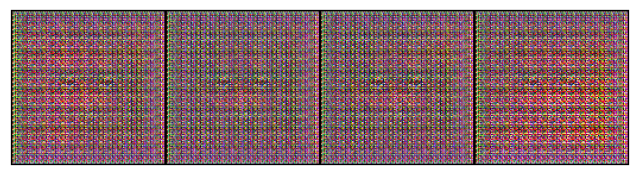

In [97]:
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (5 баллов)

### 4.1. Подсчет accuracy (3 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [106]:
df = FlickDataset()
data = get_dataloader(df,batch_size=1)
len(data)

3143

In [112]:
# generating fakes
z = torch.randn(len(data),latent_size,1,1).to(device)


In [127]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
cls = KNeighborsClassifier(1)


In [113]:
generated = generator(z)

In [139]:
discriminated = discriminator(generated)

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.07 GiB. GPU 0 has a total capacity of 14.56 GiB of which 685.81 MiB is free. Including non-PyTorch memory, this process has 13.89 GiB memory in use. Of the allocated memory 13.14 GiB is allocated by PyTorch, and 642.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [118]:
y_gen = torch.zeros(len(df),1)
y_valid = torch.ones(len(df),1)

In [129]:
loo = LeaveOneOut()

In [125]:
x_batch.shape

torch.Size([7, 3, 128, 128])

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: